# AdventureWorks Försäljningsanalys
I denna analys undersöker vi AdventureWorks databas för att besvara affärsfrågor som exempelvis:
- Produktkategorier och deras försäljning
- Försäljningstrender
- Regional försäljning

Vi använder SQL för att hämta data och python för visualisering och analys.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus


user = "SA"
password = quote_plus("AxelDatascientist1!")
server = 'localhost:1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\axelw\AppData\Local\Temp\ipykernel_56344\357612789.py:27: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


### SQL till Pandas

In [2]:
def query_df(sql: str):
    with engine.connect() as con:
        return pd.read_sql(text(sql), con)

### Matplotlib styling

In [3]:
plt.style.use('ggplot')
custom_red = '#F27272'
custom_blue = '#7272F2'

## Visualisering 1: Antal produkter per kategori
Hur många produkter finns det i varje kategori?

Tabeller som används:  
Production.ProductCategory  
Production.ProductSubcategory  
Production.Product  

Plan:  
JOINA tabellerna  
Räkna DISTINCT produkter per kategori  
Skapa vertikalt stapeldiagram  
Analysera resultatet  


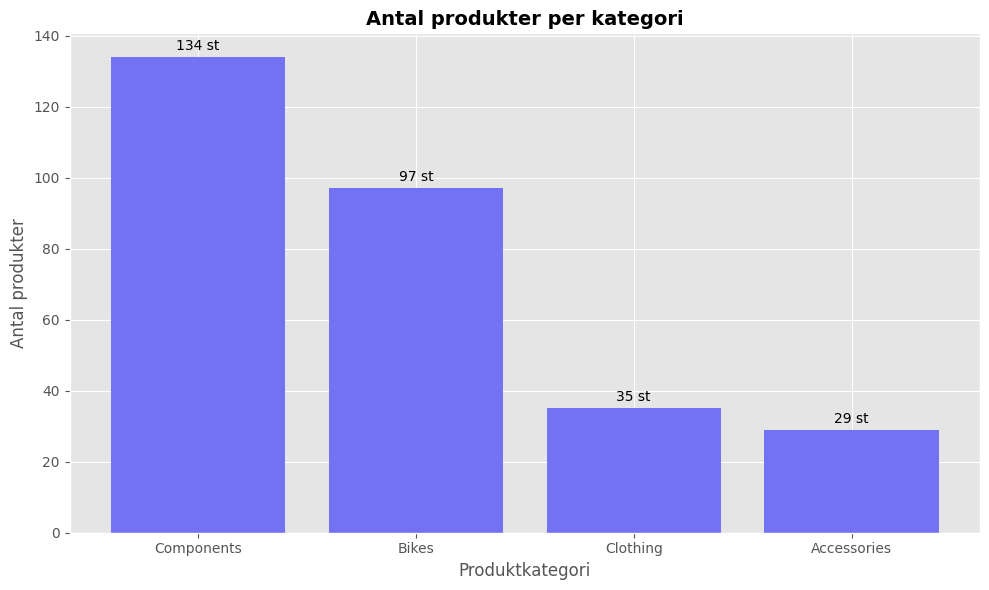

In [4]:
query_1 = '''
    SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT P.ProductID) AS ProductCount
    FROM Production.ProductCategory pc
    INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
    INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
    GROUP BY pc.Name
    ORDER BY ProductCount DESC 
'''

df_vis_1 = query_df(query_1)

fig, ax = plt.subplots(figsize = (10, 6))

bars_1 = ax.bar(df_vis_1['CategoryName'], df_vis_1['ProductCount'], color = custom_blue)

ax.set_title('Antal produkter per kategori', fontsize = 14, fontweight = 'bold')
ax.bar_label(bars_1, padding= 3, fmt='%d st')
ax.set_xlabel('Produktkategori', fontsize = 12)
ax.set_ylabel('Antal produkter', fontsize = 12)


plt.tight_layout()
plt.show()

### Insikter - Antal produkter per kategori
Components är största kategoring med 134 produkter.  
Accesoarer är minst med 29 produkter.  

Detta indikerar på att företaget är starkt fokuserat på komponenter och reservdelar. Och att accesoararer kan vara ett utvecklingsområde.

<br><br><br><br><br>

## Visualisering 2 : Försäljning per produktkategori
Vilka produktkategorier genererar mest intäkter?  
Tabeller som används:  
Production.ProductCategory  
Production.ProductSubcategory  
Production.Product  
Sales.SalesOrderDetail

Plan:  
JOINA tabellerna  
SELECT Produktkategorioer, SUM(försäljning)  
GROUP BY produktkategorier  
ORDER BY försäljning


,CategoryName,TotalRevenue
0,Bikes,94.651173
1,Components,11.802593
2,Clothing,2.120543
3,Accessories,1.272073


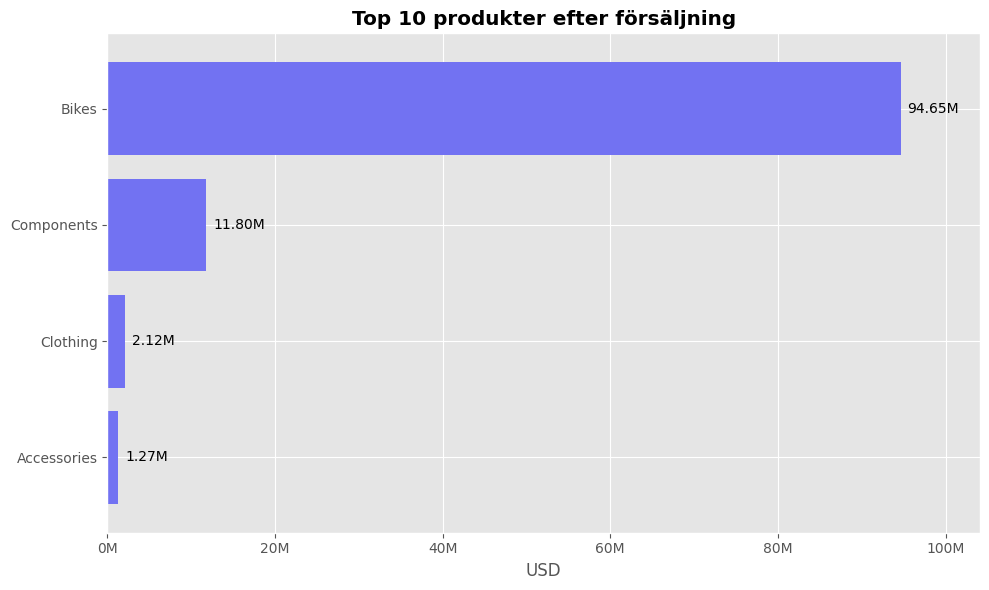

In [27]:
query_2 = '''
    SELECT 
        pc.Name AS CategoryName,
        SUM(s.LineTotal) AS TotalRevenue
    FROM Production.ProductCategory pc
    INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
    INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
    INNER JOIN Sales.SalesOrderDetail s ON p.ProductID = s.ProductID
    GROUP BY pc.Name
    ORDER BY TotalRevenue DESC
'''
df_vis_2= query_df(query_2)
df_vis_2['TotalRevenue'] = df_vis_2['TotalRevenue'] / 1_000_000
display(df_vis_2)

fig, ax = plt.subplots(figsize = (10, 6))

df_vis_2.set_index('CategoryName')['TotalRevenue'].plot(
    kind='barh',
    ax=ax,
    color= custom_blue,
    width=0.8,
    ylabel='',
)
ax.xaxis.set_major_formatter('{x:.0f}M')
ax.set_xlabel('USD')
ax.invert_yaxis()
ax.bar_label(ax.containers[0], padding=5, fmt='%.2fM')
ax.margins(x=0.10)
ax.set_title('Top 10 produkter efter försäljning', fontweight='bold')

plt.tight_layout()
plt.show()

### Insikter - Försäljning per produktkategori
Bikes är den kategori med högst försäljning på 94.65 Miljoner kr (94651172.704731 USD).  
Accesoarer är den kategori med minst försäljning på 1.27 Miljoner kr (1272072.883926 USD). 

Detta visar att även om Bikes inte är en mest sålda kategorin så är det den katogori med högst omsättning.  
Bikes är alltså en väldigt viktigt kategori för företaget.  

<br><br><br><br><br>

## Visualisering 3: Försäljningstrend över tid
#### Hur har försäljningen utvecklats över tid?
Krav på data:  
• Använd tabeller: Sales.SalesOrderHeader  
• Aggregera per månad (minst 12 månader data)  
• Sortera kronologiskt (äldst först)  

Krav på visualisering:  
• Typ: Linjediagram (line plot)  
• Titel: "Försäljningstrend per månad"  
• Visa tydlig tidslinje på X-axeln  

Krav på insikt:  
• Beskriv trenden - ökar den, minskar den, är den säsongsberoende? Nämn högsta och lägsta månaden.  

Plan:  
SELECT År, Försäljning  
GROUP BY År   
ORDER BY År


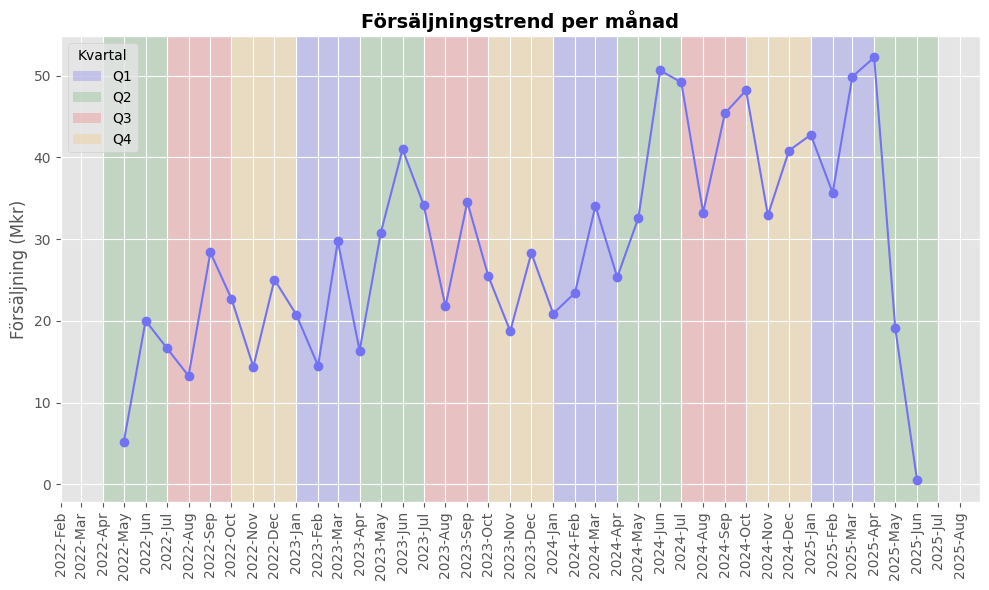

In [7]:
query_3 = '''
    SELECT 
        FORMAT(OrderDate, 'yyyy-MM') AS YearMonth,
        SUM(SubTotal) AS Revenue
    FROM Sales.SalesOrderHeader
    GROUP BY FORMAT(OrderDate, 'yyyy-MM')
    ORDER BY YearMonth
'''

df_vis_3= query_df(query_3)
df_vis_3['YearMonth'] = pd.to_datetime(df_vis_3['YearMonth'])

fig, ax = plt.subplots(figsize = (10, 6))

line_3 = ax.plot(df_vis_3['YearMonth'], df_vis_3['Revenue']/100000, marker='o', color = custom_blue)
ax.set_title('Försäljningstrend per månad', fontsize = 14, fontweight = 'bold')
ax.set_ylabel('Försäljning (Mkr)', fontsize = 12)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

quarter_colors = {
    1: 'blue',
    2: 'green',
    3: 'red',
    4: 'orange'
}

quarters = df_vis_3['YearMonth'].dt.to_period('Q').unique()

for q in quarters:
    start = q.start_time
    end = q.end_time
    color = quarter_colors[q.quarter]

    ax.axvspan(start, end, color=color, alpha=0.15, zorder=0)

legend_elements = [
    Patch(facecolor=color, alpha=0.15, label=f'Q{q}')
    for q, color in quarter_colors.items()
]

ax.legend(handles=legend_elements, title='Kvartal', loc='upper left')


plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Insikter - Försäljningstrend över tid
Den månad med högst försäljning är mars 2025.  
Den månad med lägst försäljning är maj 2025.  
Datan är dock troligtvis ofullständig efter april 2025 då ett plötsligt fritt fall sker i försäljningen.

Försäljningen ökar generellt sett under perioden bortsett från raset efter april 2025.

Försäljningen verkar inte var starkt säsongsberoende. Det man skulle kunna ana är att försäljningen är stark i Q2 och sjunker något i Q4 o om man kollar på siffrorna från 2023 och 2024.

En annan trend verkar vara att försäljningen ökar den sista månaden av varje kvartal.

<br><br><br><br><br>

## Visualisering 4: Försäljning och antal ordrar per år
#### Hur ser total försäljning och antal ordrar ut per år?
Krav på data:  
• Använd tabeller: Sales.SalesOrderHeader  
• Visa både total försäljning OCH antal ordrar  
• Gruppera per år  
• Sortera kronologiskt  

Krav på visualisering:  
• Typ: Grupperat stapeldiagram (grouped bar chart) ELLER två separata staplar per år  
• Titel: "Försäljning och antal ordrar per år"  

Krav på insikt:  
• Jämför åren - vilket år hade högst försäljning? Ökar både försäljning OCH antal ordrar, eller bara det ena?  

Plan:  
SELECT År, ordrar, försäljning  
GROUP BY År,  
ORDER BY ÅR

,Years,UniqueOrders,TotalRevenue
0,2022,1.692,14.561052
1,2023,3.830,31.604922
2,2024,14.244,43.671890
3,2025,11.699,20.008518


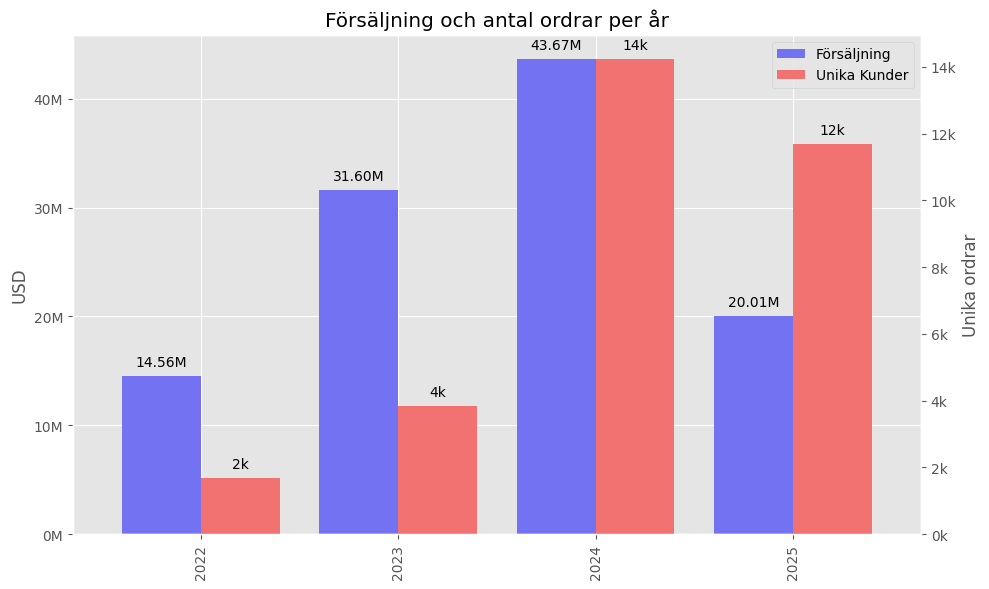

In [8]:
query_4 = '''
    SELECT 
        FORMAT(OrderDate, 'yyyy') AS Years,
        COUNT(DISTINCT SalesOrderId) AS UniqueOrders,
        SUM(SubTotal) AS TotalRevenue
    FROM Sales.SalesOrderHeader
    GROUP BY FORMAT(OrderDate, 'yyyy')
    ORDER BY Years
'''
df_vis_4= query_df(query_4)
df_vis_4['TotalRevenue'] = df_vis_4['TotalRevenue'] / 1_000_000
df_vis_4['UniqueOrders'] = df_vis_4['UniqueOrders'] / 1_000
display(df_vis_4)

fig, ax = plt.subplots(figsize = (10, 6))

df_vis_4.set_index('Years')[['TotalRevenue', 'UniqueOrders']].plot(
    kind='bar',
    ax=ax,
    secondary_y=['UniqueOrders'],
    color=[custom_blue, custom_red],
    width=0.8,
    title='Försäljning och antal ordrar per år',
    ylabel='Unika ordrar',
    xlabel=''
)

ax.right_ax.yaxis.set_major_formatter('{x:.0f}k')
ax.yaxis.set_major_formatter('{x:.0f}M')
ax.set_ylabel('USD')
ax.bar_label(ax.containers[0], padding=5, fmt='%.2fM')
ax.right_ax.bar_label(ax.right_ax.containers[0], padding=5, fmt='%.0fk')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax.right_ax.get_legend_handles_labels()
ax.legend(lines + lines2, ['Försäljning', 'Unika Kunder'])

plt.tight_layout()
plt.show()

### Insikter - Försäljning och antal ordrar per år
Det år med högst omsättning är 2024.  
Det år med flest antal ordrar är 2024.  

Mellan 2022 och 2024 ökar omsättningen och antal ordrar men inte i ett linjärt samband. 

I grafen "3: Försäljningstrend över tid" kunde vi se att det enbart fanns data på omsättning och antal ordrar fram till juni 2025 och att datan för maj och juni troligtvis inte stämmer. Därför kan vi inte heller i denna grafen dra några slutsatser från datan från 2025.

<br><br><br><br><br>


## Visualisering 5: Top 10 produkter
#### Vilka 10 produkter genererar mest försäljning?  

Krav på data:  
• Använd tabeller: Production.Product, Sales.SalesOrderDetail  
• Visa endast TOP 10 produkter  
• Sortera från högst till lägst försäljning  

Krav på visualisering:  
• Typ: Horisontellt stapeldiagram (barh)  
• Titel: "Top 10 produkter efter försäljning"  
• Sortera staplar från högst till lägst (högsta överst)  

Krav på insikt:  
• Nämn #1 produkten med exakt försäljningsvärde.  
• Vilken kategori dominerar topp 10? - För att svara på frågan behöver jag joina fler tabeller.

Plan:  
JOINA tabellerna  
SELECT produktnamn, SUM(försäljningsvärde), TOP 10   
GROUP BY produktnamn  
ORDER BY försäljningavärde  

,ProductName,ProductGroup,TotalRevenue
0,"Mountain-200 Black, 38",Bikes,4.400593
1,"Mountain-200 Black, 42",Bikes,4.009495
2,"Mountain-200 Silver, 38",Bikes,3.693678
3,"Mountain-200 Silver, 42",Bikes,3.438479
4,"Mountain-200 Silver, 46",Bikes,3.434257
5,"Mountain-200 Black, 46",Bikes,3.309673
6,"Road-250 Black, 44",Bikes,2.516857
7,"Road-250 Black, 48",Bikes,2.347656
8,"Road-250 Black, 52",Bikes,2.012448
9,"Road-150 Red, 56",Bikes,1.847819


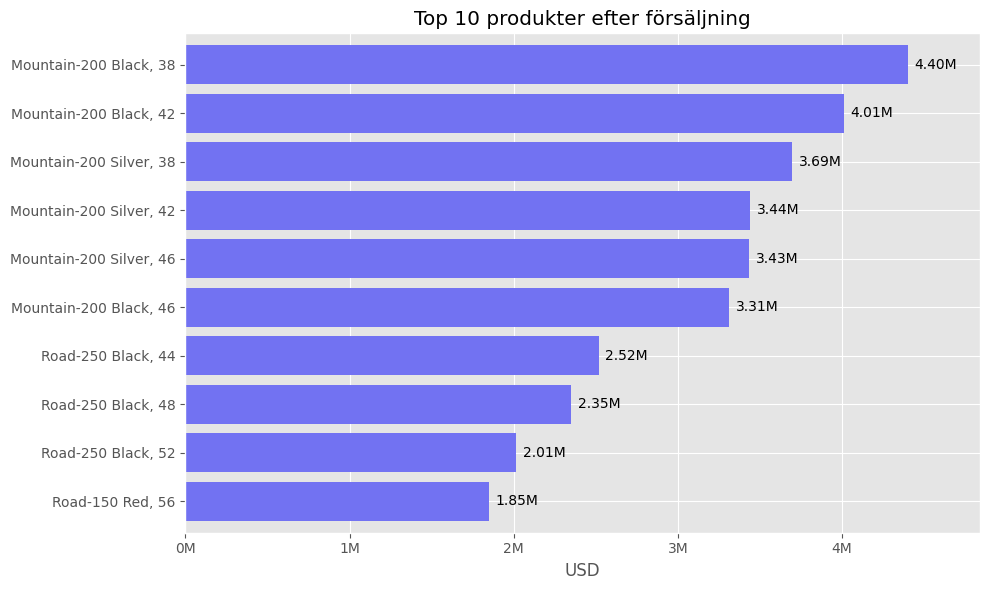

In [9]:
query_5 = '''
    SELECT TOP 10
        pp.Name AS ProductName,
        pc.Name AS ProductGroup,
        SUM(sod.LineTotal) AS TotalRevenue
    FROM Production.Product pp
    INNER JOIN Sales.SalesOrderDetail sod ON pp.ProductID = sod.ProductID
    LEFT JOIN Production.ProductSubcategory psc ON pp.ProductSubcategoryID = psc.ProductSubcategoryID
    LEFT JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
    GROUP BY pp.Name, pc.Name
    ORDER BY TotalRevenue DESC
'''
df_vis_5= query_df(query_5)
df_vis_5['TotalRevenue'] = df_vis_5['TotalRevenue'] / 1_000_000
display(df_vis_5)

fig, ax = plt.subplots(figsize = (10, 6))

df_vis_5.set_index('ProductName')['TotalRevenue'].plot(
    kind='barh',
    ax=ax,
    color= custom_blue,
    width=0.8,
    title='Top 10 produkter efter försäljning',
    ylabel=''
)
ax.xaxis.set_major_formatter('{x:.0f}M')
ax.set_xlabel('USD')
ax.invert_yaxis()
ax.bar_label(ax.containers[0], padding=5, fmt='%.2fM')
ax.margins(x=0.10)

plt.tight_layout()
plt.show()

### Insikter - Top 10 produkter
Mountain-200 Black, 38 är den produkt som genererat störst omsättning med 4,40 Mkr (4400592.800400 kr exakt).

Kategorin "Bikes" dominerar topp 10.

<br><br><br>

## Visualisering 6: Försäljning och antal kunder per region
#### Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?
Krav på data:  
• Använd tabeller: Sales.SalesTerritory, Sales.SalesOrderHeader, Sales.Customer  
• Visa total försäljning OCH antal unika kunder per region
Sortera från högst till lägst försäljning  

Krav på visualisering:  
• Typ: Grupperat stapeldiagram (grouped bar) med två staplar per region  
•Titel: "Försäljning och antal kunder per region"  
• En stapel för försäljning, en stapel för antal kunder  
• Sortera regioner från högst försäljning  

Krav på insikt:  
• Vilken region är starkast/svagast? Jämför: Har regionen med högst försäljning också flest kunder, eller har de färre kunder med högre ordervärde? Vad betyder det?  

Plan:  
JOINA tabellerna  
SELECT region, SUM(försäljning), COUNT(DISTINCT kunder)  
GROUP BY region  
ORDER BY försäljning


,Region,UniqueCustomers,TotalRevenue
0,Southwest,4565,24.184610
1,Canada,1677,16.355770
2,Northwest,3428,16.084943
3,Australia,3625,10.655336
4,Central,69,7.909009
5,Southeast,91,7.879655
6,United Kingdom,1951,7.670721
7,France,1844,7.251556
8,Northeast,57,6.939374
9,Germany,1812,4.915408


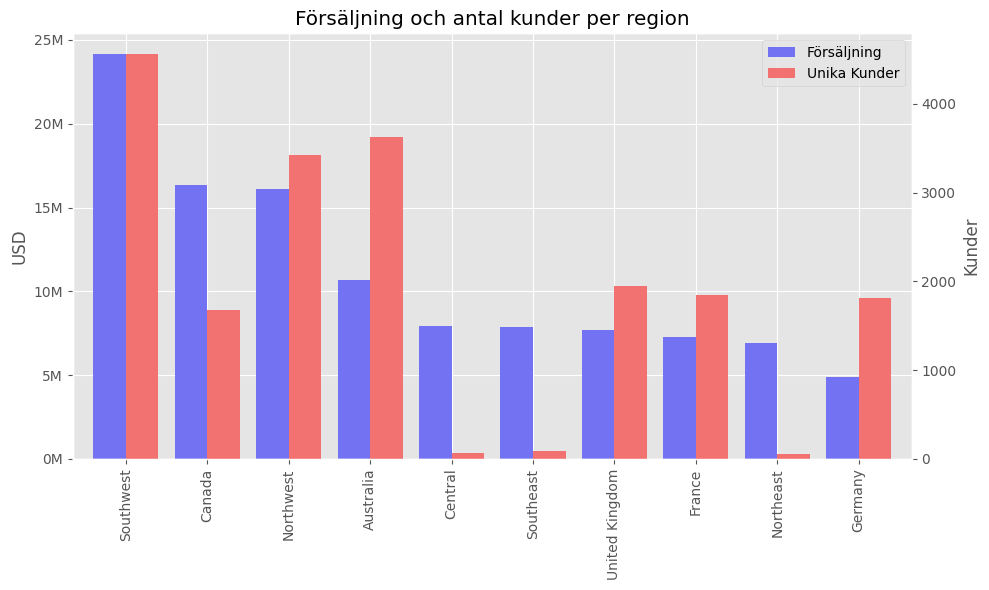

In [10]:
query_6 = '''
    SELECT 
        st.Name AS Region,
        COUNT(DISTINCT soh.CustomerID) AS UniqueCustomers,
        SUM(soh.SubTotal) AS TotalRevenue
    FROM Sales.SalesOrderHeader soh
    INNER JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
    INNER JOIN Sales.SalesTerritory st ON c.TerritoryID = st.TerritoryID
    GROUP BY st.Name
    ORDER BY TotalRevenue DESC
'''
df_vis_6 = query_df(query_6)
df_vis_6['TotalRevenue'] =  df_vis_6['TotalRevenue'] / 1_000_000
display(df_vis_6)

fig, ax = plt.subplots(figsize = (10, 6))

df_vis_6.set_index('Region')[['TotalRevenue', 'UniqueCustomers']].plot(
    kind='bar',
    ax=ax,
    secondary_y=['UniqueCustomers'],
    width = 0.8,
    color = [custom_blue, custom_red],
    title= 'Försäljning och antal kunder per region',
    ylabel='Kunder',
    xlabel=''
)

ax.yaxis.set_major_formatter('{x:.0f}M')
ax.set_ylabel('USD')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax.right_ax.get_legend_handles_labels()
ax.legend(lines + lines2, ['Försäljning', 'Unika Kunder'])

plt.tight_layout()
plt.show()

### Insikter - Försäljning och antal kunder per region
Region Southwest är starkast i både omsättning och antal unika kunder.  

Det betyder att Southwest har en balans mellan små och stora kunder jämfört med t.ex. Central där varje kund genererar en betydligt större omsättning än i southwest. Australien har betydligt mindre omsättning per kund än Southwest.

<br><br><br><br><br>

## Visualisering 7: Genomsnittligt ordervärde per region och kundtyp
Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?  

Krav på data:  
• Använd tabeller: Sales.SalesTerritory, Sales.SalesOrderHeader, Sales.Customer, Sales.Store  
• Beräkna: Total försäljning / Antal ordrar per region  
• Dela upp på kundtyp: Store (företag) vs Individual (privatperson)  
• Sortera från högst till lägst genomsnitt  

Krav på visualisering:  
• Typ: Grupperat stapeldiagram (grouped bar)  
• Titel: "Genomsnittligt ordervärde per region och kundtyp"  
• Två staplar per region: en för Store, en för Individual  
• Sortera regioner från högst genomsnitt (totalt)  

Krav på insikt:  
• Jämför Store vs Individual - vilken grupp har högre ordervärde?   Skiljer det sig mellan regioner? Vad kan förklara skillnaderna? Vilken region + kundtyp-kombination har högst ordervärde?  

Plan:
JOINA tabellerna  
SELECT region, SUM(ordervärde / antalordrar), SUM(ordervärde / antalordrar privat), SUM(ordervärde / antalordrar företag),  
GROUP BY region  
ORDER BY AOV


,Region,TotalOrderNumber,TotalRevenue,AOV,AOVPrivate,AOVBusiness
0,Central,385,7.909009e+06,20542.8805,333.4255,21026.6174
1,Northeast,352,6.939374e+06,19714.1320,653.2468,20271.4678
2,Southeast,486,7.879655e+06,16213.2820,719.9323,16774.8746
3,Canada,4067,1.635577e+07,4021.5811,586.0281,20777.3491
4,Southwest,6224,2.418461e+07,3885.7020,1044.7927,24589.1595
5,Northwest,4594,1.608494e+07,3501.2935,899.4249,23199.7686
6,France,2672,7.251556e+06,2713.9055,1064.4193,24508.1804
7,United Kingdom,3219,7.670721e+06,2382.9515,1119.0076,22760.6852
8,Germany,2623,4.915408e+06,1873.9640,1165.1821,14540.2536
9,Australia,6843,1.065534e+07,1557.1147,1348.7646,12754.6830


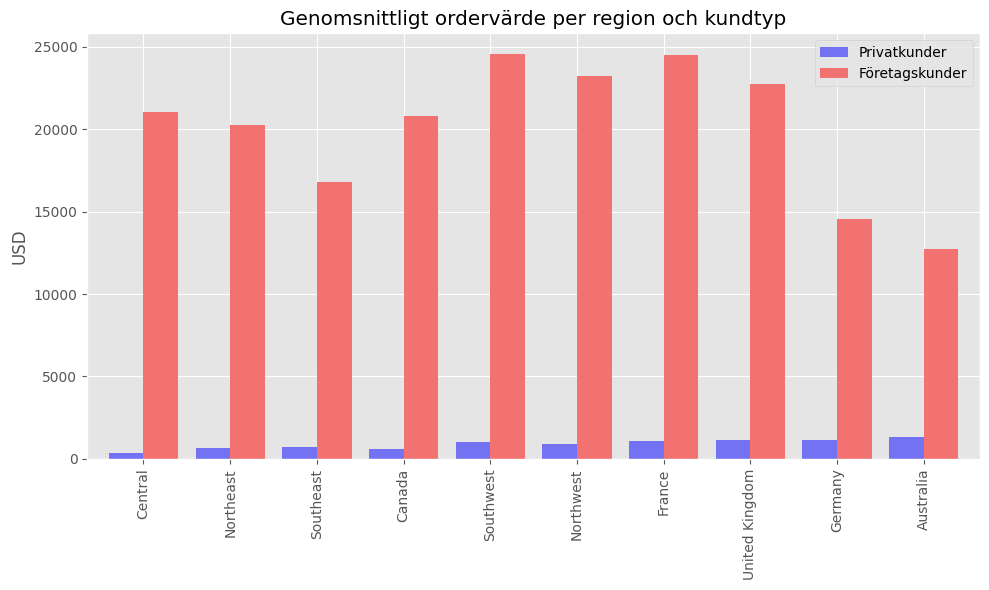

In [11]:
query_7 = '''
    SELECT
        st.Name AS Region,
        COUNT(soh.SalesOrderID) AS TotalOrderNumber,
        SUM(soh.SubTotal) AS TotalRevenue,
        SUM(soh.SubTotal) / COUNT(soh.SalesOrderID) AS AOV,
        SUM(CASE WHEN sc.StoreID IS NULL THEN soh.SubTotal END) / 
        COUNT(CASE WHEN sc.StoreID IS NULL THEN soh.SalesOrderID END) AS AOVPrivate,
        SUM(CASE WHEN sc.StoreID IS NOT NULL THEN soh.SubTotal END) / 
        COUNT(CASE WHEN sc.StoreID IS NOT NULL THEN soh.SalesOrderID END) AS AOVBusiness
    FROM Sales.SalesTerritory st
    INNER JOIN Sales.SalesOrderHeader soh ON st.TerritoryID = soh.TerritoryID
    INNER JOIN Sales.Customer sc ON soh.CustomerID = sc.CustomerID
    GROUP BY st.Name
    ORDER BY AOV DESC
'''
df_vis_7 = query_df(query_7)
display(df_vis_7)

fig, ax = plt.subplots(figsize = (10, 6))

df_vis_7.set_index('Region')[['AOVPrivate', 'AOVBusiness']].plot(
    kind='bar',
    ax=ax,
    width=0.8,
    color=[custom_blue, custom_red],
    xlabel='',
    ylabel='USD',
    title='Genomsnittligt ordervärde per region och kundtyp'
)

ax.legend(['Privatkunder', 'Företagskunder'])
plt.tight_layout()
plt.show()


### Insikter - Genomsnittligt ordervärde per region och kundtyp  

Företag har ett många gånger större genomsnittligt ordervärde (AOV) än privata kunder i alla regioner. Region Central har högsta AOV totalt och är även den region med lägsta AOV när det kommer till privatkunder. Förvånande nog så har de inte inte det högsta AOVet när det kommer till företagskunder. Detta borde betyda att region Central är stark fokuserade på företagskunder med väldigt få privata kunder som drar ner snittet på den totala AOVen. Samma logik kan appliceras på övriga regioner där AOVen starkt beror på hur pass mycket den privata marknaden drar ned snittet.